In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import greedy_modularity_communities

In [3]:
data = pd.read_csv("dblp_graph_conference.csv")
time_slices = [
    (start, start + 9)
    for start in range(data["year"].min(), data["year"].max() + 1, 10)
]

# Create graphs for each time slice
graphs = []

valid_ids = set(data["id"].astype(str))  # all valid paper IDs in the dataset
for start, end in time_slices:
    time_slice_data = data[(data["year"] >= start) & (data["year"] <= end)]
    G_time_slice = nx.DiGraph()

    for _, row in time_slice_data.iterrows():
        article_id = str(row["id"])
        references = (
            row["references"].split(";") if pd.notnull(row["references"]) else []
        )
        G_time_slice.add_node(article_id, title=row["title"], year=row["year"])

        for ref_id in set(references):
            if ref_id in valid_ids:
                G_time_slice.add_edge(article_id, ref_id)
    # Filter out isolated nodes (nodes with degree 0)
    G_time_slice = G_time_slice.subgraph(
        [node for node in G_time_slice if G_time_slice.degree(node) > 0]
    )
    graphs.append((f"{start}-{end}", G_time_slice))

for label, G in graphs:
    print(f"{label}: {len(G.nodes())} nodes, {len(G.edges())} edges")


1961-1970: 0 nodes, 0 edges
1971-1980: 22 nodes, 15 edges
1981-1990: 168 nodes, 141 edges
1991-2000: 889 nodes, 815 edges
2001-2010: 3351 nodes, 3816 edges
2011-2020: 9833 nodes, 14714 edges


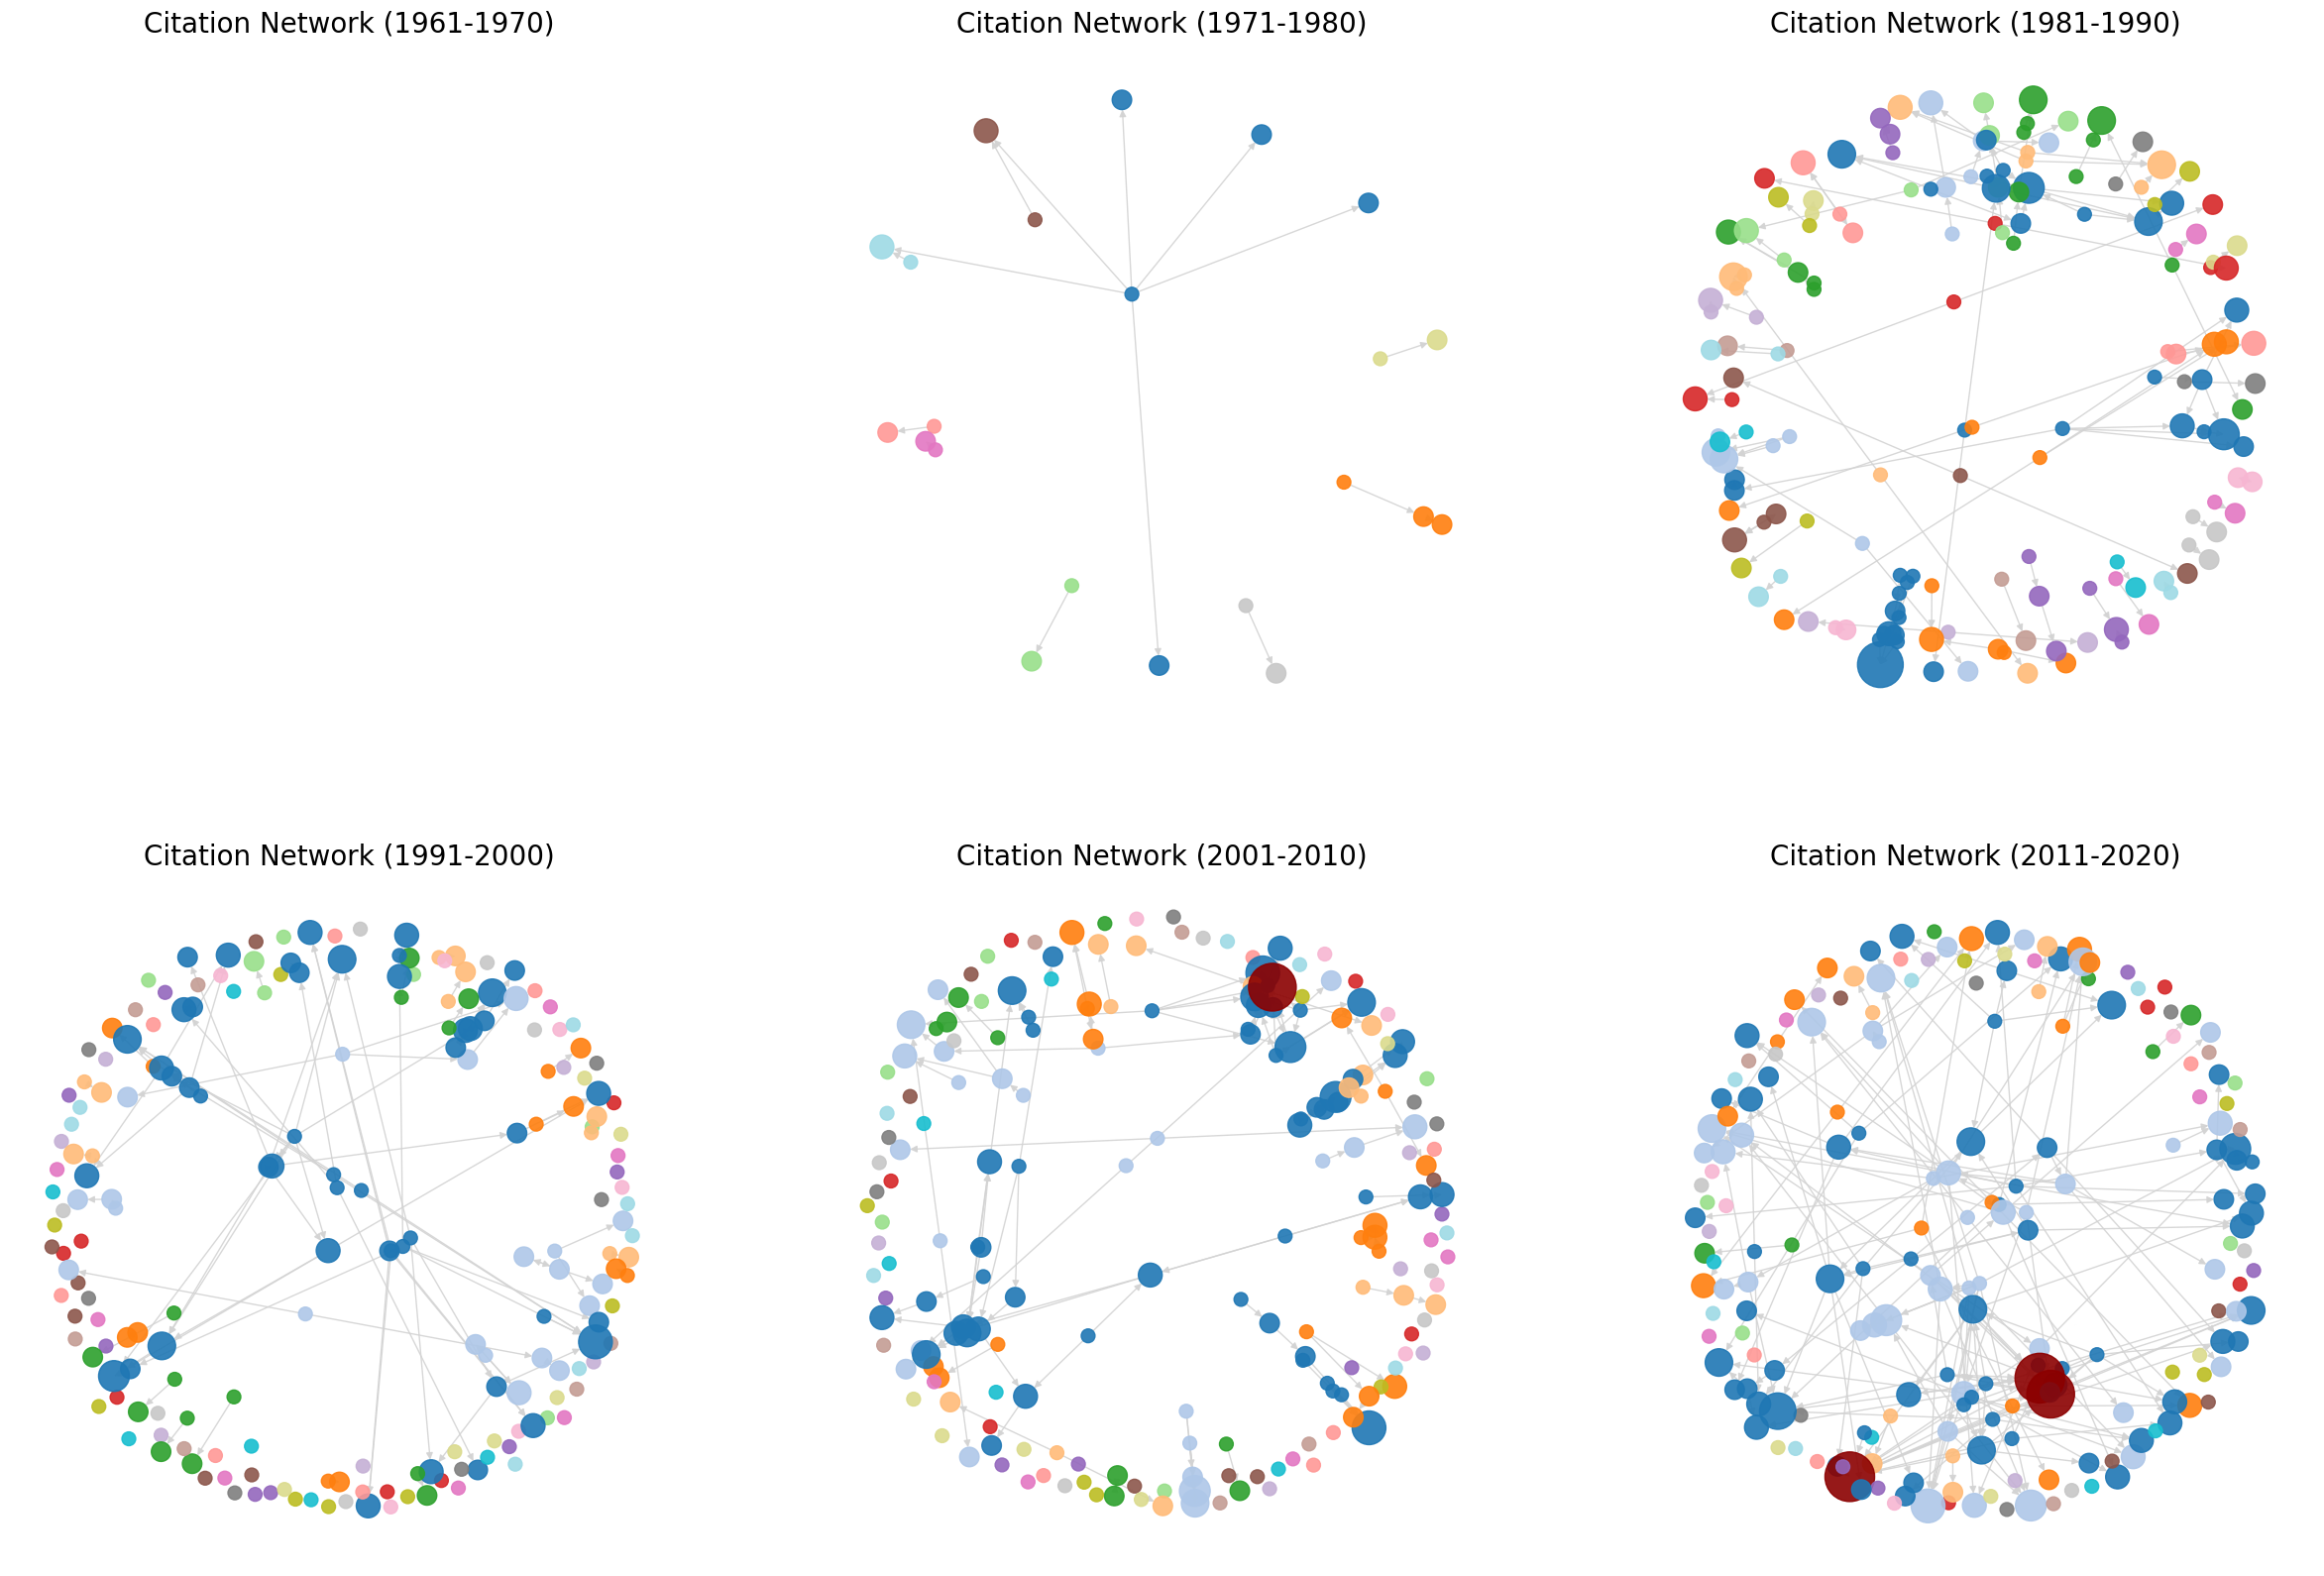

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

fig, axes = plt.subplots(2, 3, figsize=(30, 20))
axes = axes.flatten()

for i, (label, G) in enumerate(graphs):
    # select the top 200 nodes by in-degree
    G_sub = (
        G.subgraph(sorted(G.nodes, key=G.in_degree, reverse=True)[:200])
        if len(G) > 200
        else G
    )

    pos = nx.spring_layout(G_sub, seed=42, k=0.1)

    # node sizes based on in-degree
    node_sizes = [100 * (G_sub.in_degree(node) + 1) for node in G_sub]

    # detect communities in the graph
    communities = list(greedy_modularity_communities(G_sub.to_undirected()))
    colors = plt.cm.tab20(np.linspace(0, 1, len(communities)))
    community_colors = {
        node: colors[i % len(colors)]
        for i, community in enumerate(communities)
        for node in community
    }

    # highlight nodes with high citation count
    high_citation_color = "darkred"
    threshold = 10
    for node in G_sub:
        if G_sub.in_degree(node) > threshold:
            community_colors[node] = high_citation_color

    node_colors = [community_colors.get(node, "gray") for node in G_sub]

    nx.draw(
        G_sub,
        pos,
        ax=axes[i],
        node_size=node_sizes,
        node_color=node_colors,
        with_labels=False,
        edge_color="lightgray",
        alpha=0.9,
    )
    axes[i].set_title(f"Citation Network ({label})", fontsize=20)

plt.show()
